# Anomaly Detection Using Lag Plot and PCA

Data was scrubbed from article "Putting Brains Behind the Operation
Why Transformer Monitors are part of Toronto Hydro’s 21st Century Distribution Grid"

This specifically is being worked to read two utility transformer charts froma PDF

https://www.elstersolutions.com/assets/downloads/Toronto_Hydro_Transformer_Monitors.pdf

The motive is to gather realistic looking tranformer data in order to synthesize more of it for proving that a DL algo can detect anamolies in such signals


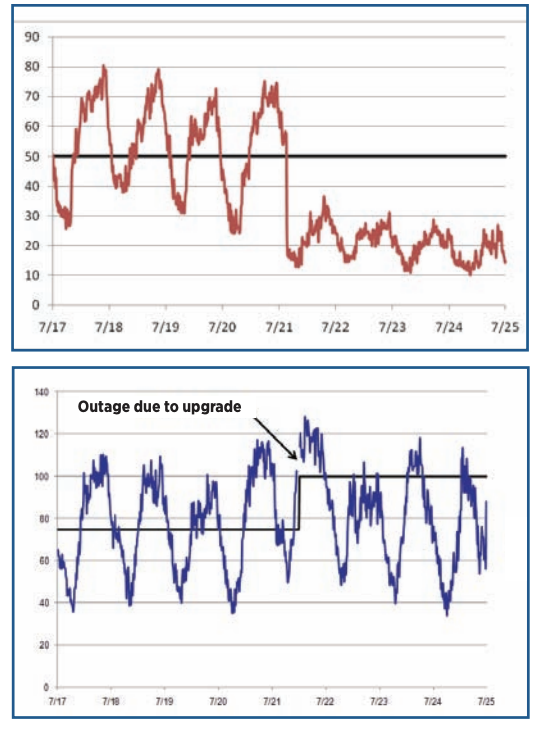


In [ ]:
from io import StringIO
import requests
import json
import pandas as pd

allBreakout = pd.read_csv('allT_breakout.csv')
redBreakout = pd.read_csv('redT_breakout.csv')
blueBreakout = pd.read_csv('blueT_breakout.csv')
simulatedNoLows = pd.read_csv('SimulatedTransformer.csv')
InjectedMomentary = pd.read_csv('InjectedMomentary.csv')

# This is where I hid the momentary

In [ ]:
InjectedMomentary.head()
InjectedMomentary[abs(InjectedMomentary.meanY - InjectedMomentary.newY) > 75]

## hides in the data pretty well doesn't it?

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
#xtx = range(45,500,45)
# set your ticks manually
#ax.xaxis.set_ticks(xtx)
ax.grid(True)
plt.plot(InjectedMomentary.X, InjectedMomentary.newY, c= 'g')

## Zoom in to look at local behavior since I know where to look

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
#xtx = range(45,500,45)
# set your ticks manually
#ax.xaxis.set_ticks(xtx)
ax.grid(True)
lo = 5500
hi = 6000
plt.plot(InjectedMomentary.X.iloc[lo:hi], InjectedMomentary.newY.iloc[lo:hi], c= 'g')

In [ ]:
injectedMomentaryStart = 5635
injectedMomentaryDuration = 4
injectedMomentaryValue = .5 *  simulatedNoLows.iloc[injectedMomentaryStart:injectedMomentaryStart + injectedMomentaryDuration].newY.max()
InjectedMomentaryNew = simulatedNoLows.copy()
InjectedMomentaryNew.loc[injectedMomentaryStart:injectedMomentaryStart + injectedMomentaryDuration,'newY'] = injectedMomentaryValue

In [ ]:
InjectedMomentaryNew.newY[5635]

In [ ]:
simulatedNoLows.newY[5635]

In [ ]:
InjectedMomentary

In [ ]:
lagDF = InjectedMomentaryNew[['X','newY']]

In [ ]:
lagDF['lagY'] =  InjectedMomentaryNew.newY.shift(1)

In [ ]:
lagDF.head()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(lagDF.newY,lagDF.lagY)
plt.show()

In [ ]:
mat = lagDF.values[1:,1:]
t = 45*np.pi/180
rot = [[np.cos(t), -np.sin(t)],[np.sin(t),np.cos(t)]]
rot_mat = np.dot(mat,rot)


In [ ]:
plt.scatter(rot_mat[:,0],rot_mat[:,1])
y_upper = 60
y_lower = -60
plt.hlines([y_upper, y_lower],xmin=50,xmax = 350,color='r')
plt.show()

In [ ]:
threshold = 60
anamoly_lo = np.argwhere(rot_mat[:,1] > threshold)
anamoly_hi = np.argwhere(rot_mat[:,1] < -threshold)

# Anamoly detected but adjusted threshold up and down

In [ ]:
InjectedMomentary

In [ ]:
import numpy as np
import scipy
from scipy import signal
scipy.__version__
rng = np.random.default_rng()

x = InjectedMomentary.newY
rng =  5000
corrs = []
for lo in range(9,300):
    hi = rng + lo
    correlation_self = signal.correlate(x[lo:hi], x[lo:hi], mode="full")
    correlation = signal.correlate(x[:rng], x[lo:hi], mode="full")/correlation_self
    corrs.append(correlation.sum())

In [ ]:
C = np.array(corrs)
lows = []
for i in range(0,100):
    lows.append(C[i:i+150].argmin())
plt.plot(C)   
plt.grid()
lo = 60
print(C[lo:lo+40].argmin()+lo)

In [ ]:
B = InjectedMomentary[['newY']].to_numpy()
B.shape

In [ ]:
# div = 1024
# blocks = 5920//div
# B[:blocks*div].reshape(blocks,div)

In [ ]:
C = B[:blocks*div]
C.shape

In [ ]:
R = C.reshape(blocks,div)
R[4].shape

In [ ]:
# plt.plot(R[4,:])

In [ ]:
np.where(np.convolve(R[2,:], [-1,1]) == 0)

# PCA rotates the matrix also so that PC0 is primary axis, PC1 is Y etc

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
mat = lagDF.values[1:,1:]
pca = PCA(n_components=2)
pca.fit(mat)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
PCA = pca.transform(mat)
plt.scatter(PCA[:,0], PCA[:,1])

In [ ]:
# plt.plot( (PCA[:,0]+PCA[:,1]+PCA[:,2]+PCA[:,3]))


In [ ]:
%%timeit
np.where(InjectedMomentary.newY.diff() == 0)

In [ ]:
%%timeit
np.where( np.convolve(InjectedMomentary.newY, [-1,1]) == 0)

In [ ]:
np.where( np.convolve(InjectedMomentary.newY, [-1,1]) == 0)

In [ ]:
t = InjectedMomentary.newY.copy()
b = np.squeeze( np.where(np.convolve(t, [-1,1])==0) )
idx = np.squeeze( np.where(t == t[b[0]]) )
t[idx] = np.NAN
idx,t[idx]

# What if injection are NAN's , not Zero?

Using convolution trick to look for strings of zeros works when derivative is zero somewhere for a few samples.

But, if NaN
s were present there instead of zeros the convoution speedup track doesn't work - but the lag trick does

In [ ]:
s = lagDF.lagY.copy()
c = np.squeeze( np.where(np.convolve(s, [-1,1])==0) )
idx = np.squeeze( np.where(s == s[c[0]]) )
s[idx] = np.NAN
idx

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(lagDF.newY,lagDF.lagY)
plt.show()

In [ ]:
mat = lagDF.values[1:,1:]
t = 45*np.pi/180
rot = [[np.cos(t), -np.sin(t)],[np.sin(t),np.cos(t)]]
rot_mat = np.dot(mat,rot)


In [ ]:
plt.scatter(rot_mat[:,0],rot_mat[:,1])
y_upper = 60
y_lower = -60
plt.hlines([y_upper, y_lower],xmin=50,xmax = 350,color='r')
plt.show()

In [ ]:
threshold = 60
anamoly_lo = np.argwhere(rot_mat[:,1] > threshold)
anamoly_hi = np.argwhere(rot_mat[:,1] < -threshold)
anamoly_lo, anamoly_hi